<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter08/Training_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
if not os.path.exists('darknet'):
    !git clone https://github.com/AlexeyAB/darknet
    %cd darknet
    !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
    # !!! In case you dont have a GPU, make sure to comment out the below 3 lines !!! #
    !sed -i 's/GPU=0/GPU=1/' Makefile
    !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
    !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
    !make
    !pip install -q torch_snippets
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
    !tar -xf open-images-bus-trucks.tar.xz
    !rm open-images-bus-trucks.tar.xz
    !wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

Cloning into 'darknet'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 14333 (delta 0), reused 0 (delta 0), pack-reused 14330
Receiving objects: 100% (14333/14333), 12.89 MiB | 24.58 MiB/s, done.
Resolving deltas: 100% (9776/9776), done.
/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-varia

In [ ]:
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x

In [ ]:
%%writefile data/obj.names
bus
truck

Writing data/obj.names


In [ ]:
%%writefile data/obj.data
classes = 2
train = data/train.txt
valid = data/val.txt
names = data/obj.names
backup = backup/

Writing data/obj.data


In [ ]:
!mkdir -p data/obj
!cp -r open-images-bus-trucks/images/* data/obj/
!cp -r open-images-bus-trucks/yolo_labels/all/{train,val}.txt data/
!cp -r open-images-bus-trucks/yolo_labels/all/labels/*.txt data/obj/

In [ ]:
# create a copy of existing configuration and modify it in place
!cp cfg/yolov4-tiny-custom.cfg cfg/yolov4-tiny-bus-trucks.cfg
# max_batches to 4000 (since the dataset is small enough)
!sed -i 's/max_batches = 500200/max_batches=4000/' cfg/yolov4-tiny-bus-trucks.cfg
# number of sub-batches per batch
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov4-tiny-bus-trucks.cfg
# number of batches after which learning rate is decayed
!sed -i 's/steps=400000,450000/steps=3200,3600/' cfg/yolov4-tiny-bus-trucks.cfg
# number of classes is 2 as opposed to 80 (which is the number of COCO classes)
!sed -i 's/classes=80/classes=2/g' cfg/yolov4-tiny-bus-trucks.cfg
# in the classification and regression heads, change number of output convolution filters
# from 255 -> 21 and 57 -> 33, since we have fewer classes we don't need as many filters
!sed -i 's/filters=255/filters=21/g' cfg/yolov4-tiny-bus-trucks.cfg
!sed -i 's/filters=57/filters=33/g' cfg/yolov4-tiny-bus-trucks.cfg

In [ ]:
!wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29
!cp yolov4-tiny.conv.29 build/darknet/x64/

In [ ]:
!./darknet detector train data/obj.data cfg/yolov4-tiny-bus-trucks.cfg yolov4-tiny.conv.29 -dont_show -mapLastAt

Streaming output truncated to the last 5000 lines.
 total_bbox = 28861, rewritten_bbox = 0.266796 % 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 30 Avg (IOU: 0.253837, GIOU: 0.226252), Class: 0.512278, Obj: 0.035657, No Obj: 0.003119, .5R: 0.000000, .75R: 0.000000, count: 3, class_loss = 1.006398, iou_loss = 0.030554, total_loss = 1.036951 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 37 Avg (IOU: 0.272861, GIOU: 0.124810), Class: 0.489438, Obj: 0.001360, No Obj: 0.001263, .5R: 0.000000, .75R: 0.000000, count: 4, class_loss = 1.592821, iou_loss = 0.524624, total_loss = 2.117445 
 total_bbox = 28868, rewritten_bbox = 0.266731 % 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 30 Avg (IOU: 0.441726, GIOU: 0.394106), Class: 0.537547, Obj: 0.008450, No Obj: 0.002911, .5R: 0.200000, .75R: 0.000000, count: 5, class_loss = 1.765674, iou_loss = 0.170821, total_loss = 1.936495 
v3 (iou loss, Normalizer: (iou: 0.07, cls: 1.00) Region 37 Avg (IOU: 0.533825, GIOU: 0.

2020-11-09 03:24:37.260 | INFO     | torch_snippets.loader:Glob:181 - 3 files found at pred_*.png


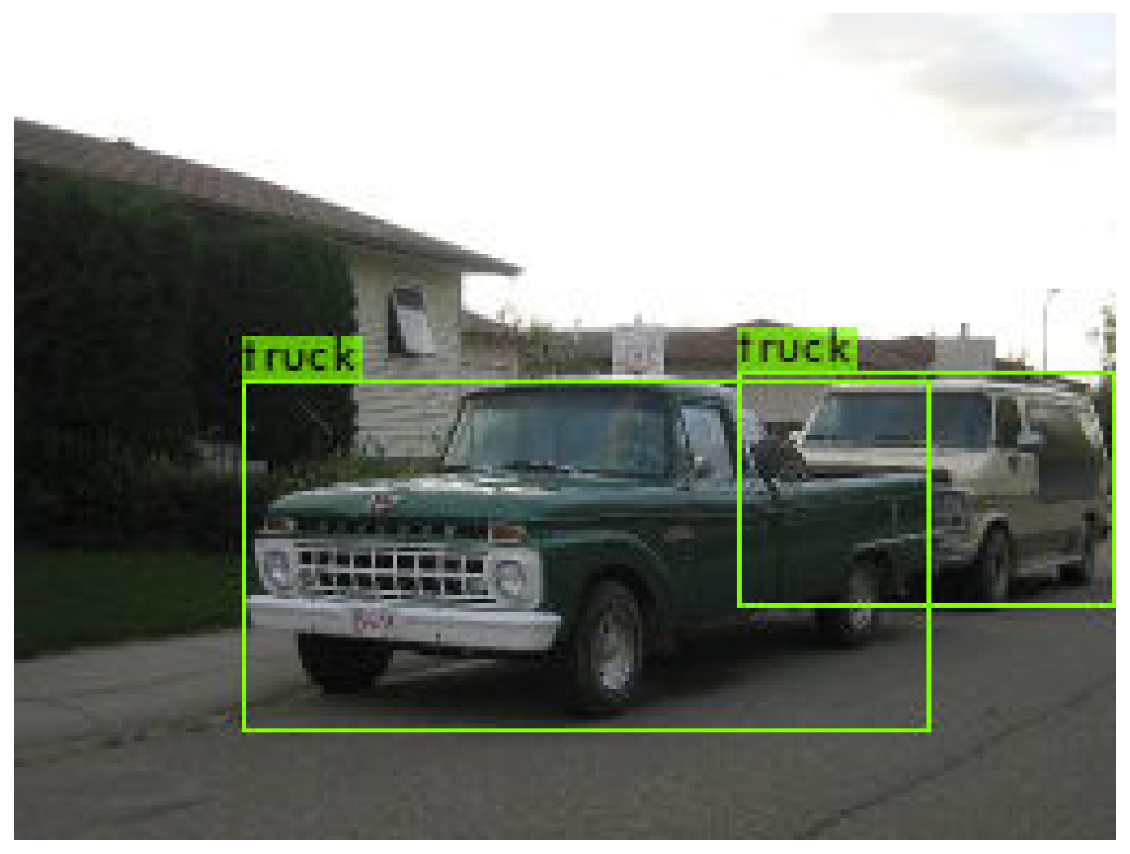

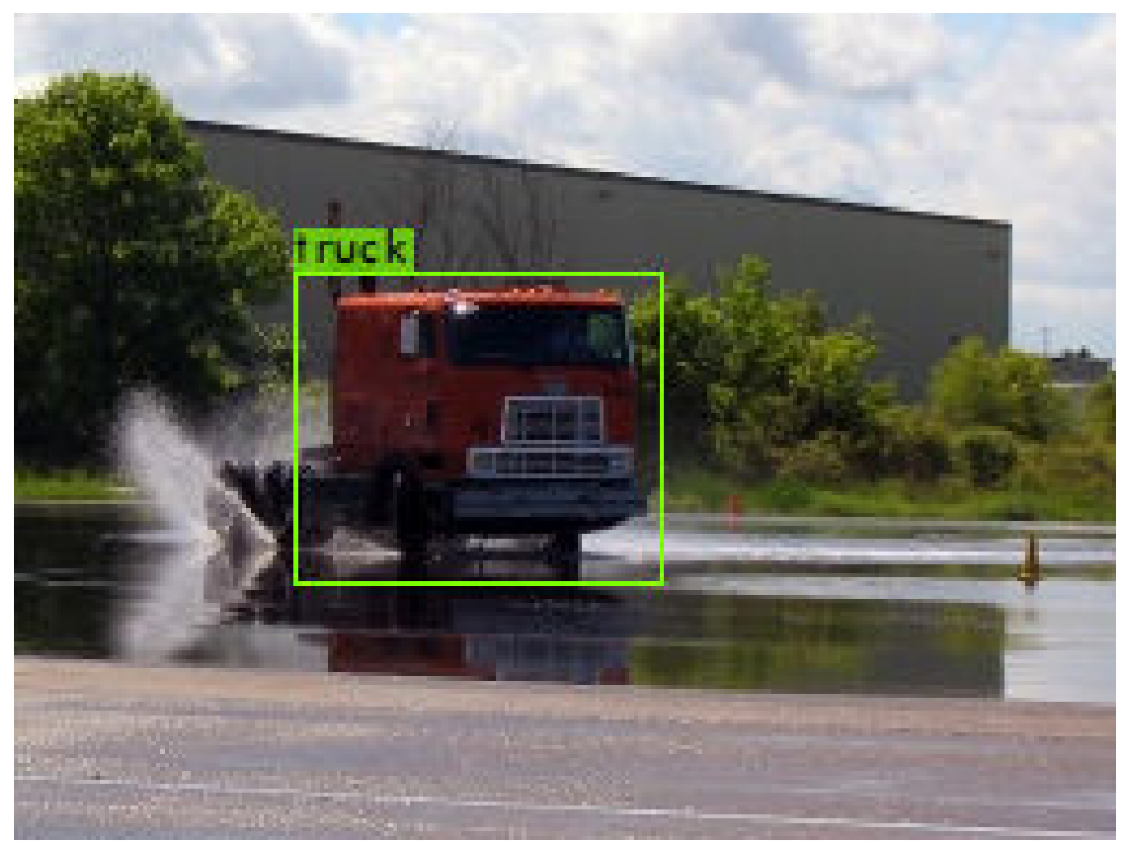

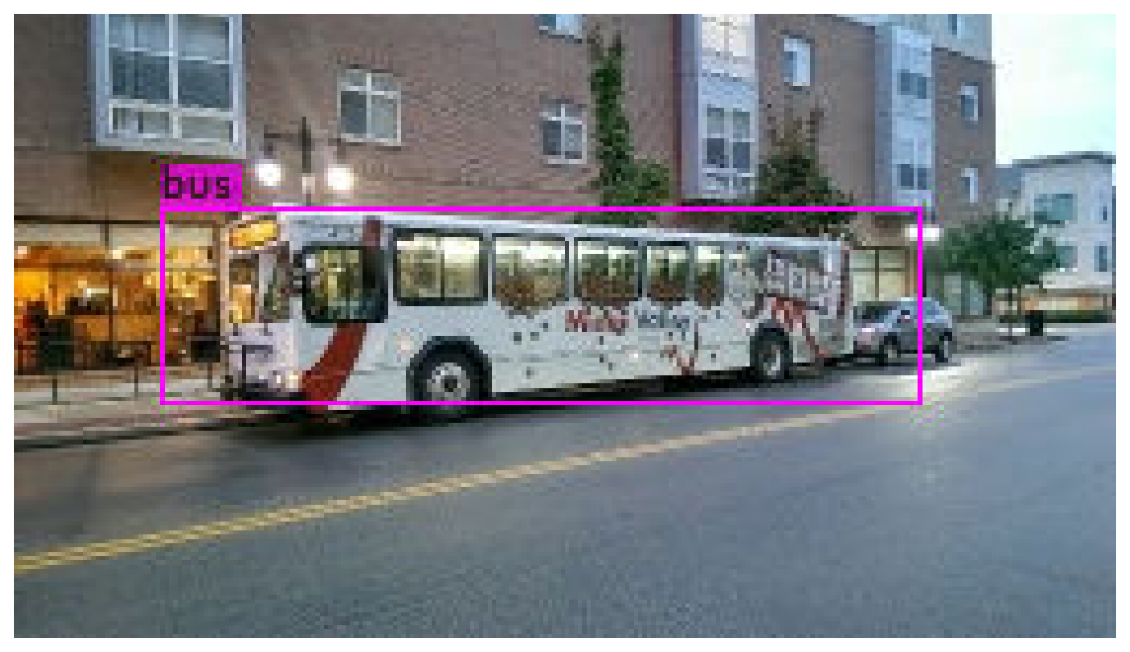

In [5]:
from torch_snippets import Glob, stem, show, read
# upload your own images to a folder
image_paths = Glob('images-of-trucks-and-busses')
for f in image_paths:
    !./darknet detector test data/obj.data cfg/yolov4-tiny-bus-trucks.cfg\
    backup/yolov4-tiny-bus-trucks_4000.weights {f}
    !mv predictions.jpg {stem(f)}_pred.jpg

for i in Glob('*_pred.jpg', silent=True):
    show(read(i, 1), sz=20)